In [ ]:
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
"""
Load & Transform Dataset
"""
transforms = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.RandomHorizontalFlip(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] #normalize with mean & stdev of .5- 3x for each for RGB channels
)

#load datasets5
train_set = datasets.CIFAR10(root="../../data/",
                             train=True,
                             transform=transforms,
                             download=True)
test_set = datasets.CIFAR10(root="../../data/",
                            train=False,
                            transform=transforms,)

#data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=100,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          shuffle=False,
                                          batch_size=100)

Files already downloaded and verified


In [ ]:
#get dataset size
first_datapoint = train_set[0]
print("Dataset Size: {}x{}x{}".format(*tuple(first_datapoint[0].size())))

Dataset Size: 3x32x32


In [ ]:
"""
Convolutional Network with three convolutional layers and three fully•••••••••••••••••••••••••••••••••••••••••• connected layers
"""
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #not sure why all examples use python2 syntax super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
                #block1
                nn.Conv2d(3, 32, kernel_size=4, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=.05)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
          nn.Dropout(p=.1),
          nn.Linear(128*3*3, 288),
          nn.ReLU(),
          nn.Linear(288, 144),
          nn.ReLU(),
          nn.Dropout(p=.1),
          nn.Linear(144, num_classes)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
"""
Initialize training parameters
"""
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
num_epochs = 150

cuda:0


In [ ]:
"""
Setup Model + optimizer and loss function
"""
model = ConvNet(num_classes).to(device) #train on selected device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001) #start with learning rate of .001

In [ ]:
"""
Train model
"""

losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) #feed images into model
        loss = criterion(outputs, labels) #calculate loss
        optimizer.zero_grad() #reset gradient on each pass
        loss.backward() #backpropogation
        optimizer.step() #update parameters based on gradient
        running_loss += loss.item() * images.size(0) 
        if (i+1) % 100 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)

Epoch [1/200], Step [100/500], Loss: 2.0080
Epoch [1/200], Step [200/500], Loss: 1.7061
Epoch [1/200], Step [300/500], Loss: 1.4720
Epoch [1/200], Step [400/500], Loss: 1.5576
Epoch [1/200], Step [500/500], Loss: 1.2964
Epoch [2/200], Step [100/500], Loss: 1.2621
Epoch [2/200], Step [200/500], Loss: 1.2774
Epoch [2/200], Step [300/500], Loss: 1.0896
Epoch [2/200], Step [400/500], Loss: 1.2536
Epoch [2/200], Step [500/500], Loss: 0.9286
Epoch [3/200], Step [100/500], Loss: 0.8982
Epoch [3/200], Step [200/500], Loss: 1.0496
Epoch [3/200], Step [300/500], Loss: 0.8939
Epoch [3/200], Step [400/500], Loss: 1.0607
Epoch [3/200], Step [500/500], Loss: 0.9965
Epoch [4/200], Step [100/500], Loss: 0.8393
Epoch [4/200], Step [200/500], Loss: 1.1088
Epoch [4/200], Step [300/500], Loss: 0.9602
Epoch [4/200], Step [400/500], Loss: 0.8441
Epoch [4/200], Step [500/500], Loss: 0.8629
Epoch [5/200], Step [100/500], Loss: 1.0700
Epoch [5/200], Step [200/500], Loss: 0.6036
Epoch [5/200], Step [300/500], L

In [ ]:
"""
Evaluate model accuracy
"""
model.eval() 
correct = 0
total = 0
with torch.no_grad():
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() #.item returns as python number

print("Model achieved {}% accuracy".format((correct/total)*100))

Model achieved 79.97% accuracy


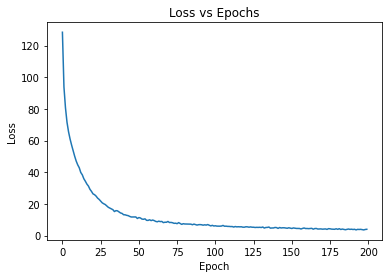

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss vs Epochs")

plt.show()